In [1]:
%matplotlib inline
import itertools
import numpy as np
import matplotlib
# matplotlib.use('PS')
from matplotlib import pyplot as plt
plt.style.use('bmh')
from numba import jit
from numba import njit
from time import time
# Spline interpolation
from scipy.interpolate import RectBivariateSpline
# Multiprocessing:
from concurrent import futures as fut
from concurrent.futures import ProcessPoolExecutor, as_completed

from ipywidgets import FloatProgress
from IPython.display import display


In [2]:
import sys
# PATH = '$HOME/git/LCS/notebooks'
sys.path.insert(0, './utility/')
import importlib

In [3]:
import multiprocessing

n_cpus = multiprocessing.cpu_count()
n_cpus

12

In [4]:

factor = 20
NX = int(100*factor)
NY =  int(50*factor)
n__ = 8
n = n__
num_lines_ = 5
smudge = 1.0

fig_s = (14, int(14 * NY / NX))

# print(fig_num)

In [5]:
##double gyre functions
import double_gyre
importlib.reload(double_gyre)#do a reload to set A and e properly
t_offset = 0
T0 = 0. + t_offset
TMAX = 20. + t_offset
A_ = 0.1
e_ = 0.1
h_= 0.1
domain_len = 2
strain_res = 1*h_ / 100
spat_res = 0.2
fig_num = '_t%d-%de%0.2fA%0.2f_' % (T0, TMAX, e_, A_)
gyreObj = double_gyre
gyreObj.setGyreVars(A_, e_)
f = gyreObj.f
grid_of_particles = gyreObj.grid_of_particles
doublegyre = gyreObj.doublegyre
has_para = True

print('T0:', T0)

T0: 0.0


In [6]:
# ##norkyst 800 test
# import norkyst
# importlib.reload(norkyst)
# backward = False
# norkystObj = norkyst.norkystHandler(back=backward)
# norkystObj(NX, NY)
# T0 = 0.
# t_offset = 0
# h_= norkystObj.time_res * (-1)**backward
# TMAX = h_ * (norkystObj.dims[0]-2)
# strain_res = 1.0*h_ / 100
# h_ = 2 * h_
# spat_res = norkystObj.x_res * 1.0

# fig_num = '_t%d-%d_' % (T0, TMAX)
# domain_len = max(norkystObj.x.values[-1] - norkystObj.x.values[0], norkystObj.y.values[-1] - norkystObj.y.values[0])
# domain_len = domain_len/100
# print('Orig data dims: ', norkyst.data.u.shape)
# print('Dimensions', norkystObj.dims)
# print('10/1.5 AB res: ', domain_len)
# print('Grid resolution: ',spat_res)
# has_para=False

# grid_of_particles = norkystObj.grid_of_particles
# f = norkystObj.f

In [7]:
#these should be put in another script

# 4th order Runge-Kutta integrator
# X0 is a two-component vector [x, y]

def rk4(X, t, h, f):
    k1 = f(X,          t)
    k2 = f(X + k1*h/2., t + h/2.)
    k3 = f(X + k2*h/2., t + h/2.)
    k4 = f(X + k3*h,   t + h)
    return X + h*(k1 + 2.*k2 + 2.*k3 + k4) / 6.


# Function to calculate endpoints from
# initial positions X0 at t = 0, moving forward
# until t = tmax, using the given timestep and
# integrator

def endpoints(X0, tmax, h, integrator, f, t=0):
    # Number of timesteps
    Nt = np.abs(int((tmax - t) / h))
    # Array to hold positions
    X  = np.zeros((*X0.shape,))
    # Initial position
    X[:,:] = X0
    # Loop over all timesteps
    i = 1
#     print(h*(t-tmax))
    while h*(t - tmax) < 0:
        # Ensure we end up at correct time
        if h > 0:
            h = min(h,np.abs(tmax - t))
        elif h < 0:
            h = min(h,-tmax + t)
        X = integrator(X, t, h, f)
        t += h
        i += 1
    # Return entire trajectory
    return X

In [8]:
# # Transport parameters
# t0 = T0
# tmax =  TMAX
# h    =  h_

# # Main grid initial points
# Np   = NX*NY
# X0m  = grid_of_particles(NX, NY, wx = 2.02, wy = 1.01)
# Nx   = X0m.shape[1]
# Ny   = X0m.shape[2]
# # Grid parameters of original grid
# dxm = X0m[0,1,0] - X0m[0,0,0]
# dym = X0m[1,0,1] - X0m[1,0,0]

# # Auxiliary grid initial points
# dxa        = dxm / 100
# dya        = dym / 100

# # n_p = int(n__/2)
# X0a        = np.empty((2, 2, 2, Nx, Ny))
# X1a        = np.empty((2, 2, 2, Nx, Ny))

# # for i in range(0,n_p):
# #     X0a[i,0,:] = X0m + np.array([-dxa*(n_p - i), 0]).reshape(2,1,1)
# # for i in range(n_p, n__):
# #     X0a[i,0,:] = X0m + np.array([dxa*(i+1 - n_p), 0]).reshape(2,1,1)
# # for i in range(0, n_p):
# #     X0a[i,1,:] = X0m + np.array([0, -dya*(n_p - i)]).reshape(2,1,1) 
# # for i in range(n_p, n__):
# #     X0a[i,1,:] = X0m + np.array([0, dya*(i+1 - n_p)]).reshape(2,1,1)   
    
# X0a[0,0,:] = X0m + np.array([-dxa, 0]).reshape(2,1,1)
# X0a[1,0,:] = X0m + np.array([ dxa, 0]).reshape(2,1,1)
# X0a[0,1,:] = X0m + np.array([ 0,-dya]).reshape(2,1,1)
# X0a[1,1,:] = X0m + np.array([ 0, dya]).reshape(2,1,1)

# print('Main grid consists of %s x %s = %s points.' % (Nx, Ny, Nx*Ny))
# print('Corners: ', (X0m[0,0,0], X0m[1,0,0]), (X0m[0,-1,-1], X0m[1,-1,-1]))
# print('dxm = ', dxm, 'dym = ', dym)
# print('dxa = ', dxa, 'dya = ', dya)

# # Progress bar
# progressbar = FloatProgress(min = 0, max = 1+2*2)
# display(progressbar)
# futures = []
# # Trajectory endpoints
# if has_para:
#     X1m   = endpoints(X0m, tmax, h, rk4, f, t=t0)
#     progressbar.value += 1
#     for i in range(2):
#         X1a[i,0,:] = endpoints(X0a[i,0,:], tmax, h, rk4, f, t=t0)
#         progressbar.value += 1
#         X1a[i,1,:] = endpoints(X0a[i,1,:], tmax, h, rk4, f, t=t0)
#         progressbar.value += 1
# else:
#     with ProcessPoolExecutor(4) as executor:
#         futures.append(executor.submit(endpoints,
#                                            X0m, tmax, h, rk4, f, t0))
        
#         for i in range(2):
#             futures.append(executor.submit(endpoints,
#                                            X0a[i,0,:,:,:], tmax, h, rk4, f, t0))
#         for i in range(2):
#             futures.append(executor.submit(endpoints,
#                                            X0a[i,1,:,:,:], tmax, h, rk4, f, t0))
    
#     count = 0
# #     fut.wait(return_when='ALL_COMPLETED')
#     for p in (futures):
#         progressbar.value += 1
#         try:
#             if count == 0:
#                 X1m = p.result()
#             if count < 2 + 1:
#                 X1a[count - 1,0,:] = p.result()
# #                 abc = p.result()
#                 count += 1
#             else:
#                 X1a[count - 2 - 1,1,:] = p.result()
#                 count += 1
                
#         except IndexError:
#             pass
    
# # print((abc))   
# # X1a[0,0,:] = endpoints(X0a[0,0,:], tmax, h, rk4, f, t=t0)
# # progressbar.value += 1
# # X1a[1,0,:] = endpoints(X0a[1,0,:], tmax, h, rk4, f, t=t0)
# # progressbar.value += 1
# # X1a[0,1,:] = endpoints(X0a[0,1,:], tmax, h, rk4, f, t=t0)
# # progressbar.value += 1
# # X1a[1,1,:] = endpoints(X0a[1,1,:], tmax, h, rk4, f, t=t0)
# # progressbar.value += 1

# # Flow maps
# FMm = X1m - X0m
# FMa = X1a - X0a

# # Save results to disk
# np.save('../data/X0m_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0), X0m)
# np.save('../data/X0a_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0), X0a)
# np.save('../data/X1m_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0), X1m)
# np.save('../data/X1a_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0), X1a)
# np.save('../data/FMm_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0), FMm)
# np.save('../data/FMa_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0), FMa)

In [9]:
Nx = NX
Ny =  NY
t0 = T0
tmax = TMAX

# Load data from disk
X0m = np.load('../data/X0m_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))
X0a = np.load('../data/X0a_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))
X1m = np.load('../data/X1m_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))
X1a = np.load('../data/X1a_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))
FMm = np.load('../data/FMm_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))
FMa = np.load('../data/FMa_Nx_%s_Ny_%s_Tmax_%03f_t0_%03f.npy' % (Nx, Ny, tmax, t0))
X0 = X0m
# Grid parameters of original grid
dxm = X0m[0,1,0] - X0m[0,0,0]
dym = X0m[1,0,1] - X0m[1,0,0]
# Grid parameter of auxiliary grid
dxa = X0m[0,0,0] - X0a[0,0,0,0,0]
dya = X0m[1,0,0] - X0a[0,1,1,0,0]

print('Main grid consists of %s x %s = %s points.' % (Nx, Ny, Nx*Ny))
print('Corners: ', (X0m[0,0,0], X0m[1,0,0]), (X0m[0,-1,-1], X0m[1,-1,-1]))
print('dxm = ', dxm, 'dym = ', dym)
print('dxa = ', dxa, 'dya = ', dya)

Main grid consists of 2000 x 1000 = 2000000 points.
Corners:  (-0.010000000000000009, -0.0050000000000000044) (2.01, 1.005)
dxm =  0.0010105052526263123 dym =  0.0010110110110110107
dxa =  1.010505252626269e-05 dya =  1.0110110110110072e-05


In [10]:
def dFMm_t0_t(x_):
    dFMm = np.ones((Nx, Ny, 2, 2))
    #### Derivatives for original array ####
    # dFMm_x/dx
    dFMm[1:-1, :  ,0,0] = (   x_[0,2:  , :  ] -   x_[0, :-2, :  ] )                     / (2*dxm) # Central finite difference
    dFMm[   0, :  ,0,0] = ( 4*x_[0,   1, :  ] - 3*x_[0,   0, :  ] - 2*x_[0,   2, :  ]) / (2*dxm)  # One-sided finite difference
    dFMm[  -1, :  ,0,0] = ( 3*x_[0,  -1, :  ] - 4*x_[0,  -2, :  ] + 2*x_[0,  -3, :  ]) / (2*dxm)  # One-sided finite difference
    # dFMm_x/dy
    dFMm[ :  ,1:-1,0,1] = (   x_[0, :  , 2: ] -   x_[0, :  , :-2] )                     / (2*dym) # Central finite difference
    dFMm[ :  ,   0,0,1] = ( 4*x_[0, :  ,   1] - 3*x_[0, :  ,   0] - 2*x_[0, :  ,   2]) / (2*dym)  # One-sided finite difference
    dFMm[ :  ,  -1,0,1] = ( 3*x_[0, :  ,  -1] - 4*x_[0, :  ,  -2] + 2*x_[0, :  ,  -3]) / (2*dym)  # One-sided finite difference
    # dFMm_y/dx
    dFMm[1:-1, :  ,1,0] = (   x_[1,2:  , :  ] -   x_[1, :-2, :  ] )                     / (2*dxm) # Central finite difference
    dFMm[   0, :  ,1,0] = ( 4*x_[1,   1, :  ] - 3*x_[1,   0, :  ] - 2*x_[1,   2, :  ]) / (2*dxm)  # One-sided finite difference
    dFMm[  -1, :  ,1,0] = ( 3*x_[1,  -1, :  ] - 4*x_[1,  -2, :  ] + 2*x_[1,  -3, :  ]) / (2*dxm)  # One-sided finite difference
    # dFMm_y/dy
    dFMm[ :  ,1:-1,1,1] = (   x_[1, :  , 2: ] -   x_[1, :  , :-2] )                      / (2*dym) # Central finite difference
    dFMm[ :  ,   0,1,1] = ( 4*x_[1, :  ,   1] - 3*x_[1, :  ,   0] - 2*x_[1, :  ,   2] ) / (2*dym)  # One-sided finite difference
    dFMm[ :  ,  -1,1,1] = ( 3*x_[1, :  ,  -1] - 4*x_[1, :  ,  -2] + 2*x_[1, :  ,   -3]) / (2*dym)  # One-sided finite difference
    return dFMm
def dFMa_t0_t(x_):
    dFMa = np.ones((Nx, Ny, 2, 2))
    #### Derivatives for auxiliary array ####
    # dx/dx
    #FMa -> X1a
    dFMa[:,:,0,0] = ( X1a[0,0,0,:,:] - X1a[1,0,0,:,:] ) / (2*dxa) # Central finite difference
    # dx/dy
    dFMa[:,:,0,1] = ( X1a[0,1,0,:,:] - X1a[1,1,0,:,:] ) / (2*dya) # Central finite difference
    # dx/dx
    dFMa[:,:,1,0] = ( X1a[0,0,1,:,:] - X1a[1,0,1,:,:] ) / (2*dxa) # Central finite difference
    # dx/dy
    dFMa[:,:,1,1] = ( X1a[0,1,1,:,:] - X1a[1,1,1,:,:] ) / (2*dya) # Central finite difference
    return dFMa

In [11]:
# Arrays to hold derivatives for original array and auxiliary array
dFMm = np.ones((Nx, Ny, 2, 2))
dFMa = np.ones((Nx, Ny, 2, 2))

dFMm = dFMm_t0_t(X1m)
dFMa = dFMa_t0_t(X1a)
CGm = np.matmul(np.transpose(dFMm, axes = (0,1,3,2)), dFMm)
CGa = np.matmul(np.transpose(dFMa, axes = (0,1,3,2)), dFMa)

vals_m, vecs_m = np.linalg.eigh(CGm)
vals_a, vecs_a = np.linalg.eigh(CGa)
# Store values and vectors separately for less indexing hassle
lmbd1_ = (vals_m[:,:,0])
lmbd2_ = (vals_m[:,:,1])
xi1_     = vecs_a[:,:,:,0]
xi2_     = vecs_a[:,:,:,1]

In [12]:
np.where(np.abs(np.sqrt(xi1_[:,:,0]**2 + xi1_[:,:,1]**2) - 1) > 1e-7)


(array([], dtype=int64), array([], dtype=int64))

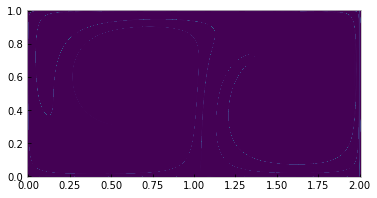

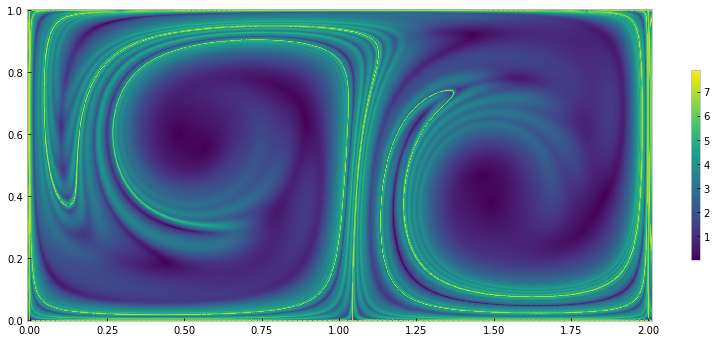

In [13]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111, aspect = 'equal')

mesh = plt.pcolormesh(X0m[0,:,:], X0m[1,:,:], lmbd2_)
# plt.colorbar(mesh, shrink = 0.6)
# plt.xlim(-0.02, 2.02)
# plt.ylim(-0.01, 1.01)


fig = plt.figure(figsize = fig_s)
ax = fig.add_subplot(111, aspect = 'equal')
mesh = plt.pcolormesh(X0m[0,:,:], X0m[1,:,:], np.log(np.sqrt(lmbd2_))/(1))
plt.colorbar(mesh, shrink = 0.5)
plt.savefig('out' + '/ftle_field' + fig_num + '.png')
# plt.xlim(-0.02, 2.02)
# plt.ylim(-0.01, 1.01)

In [14]:
# fig = plt.figure(figsize = (14,14))
# ax = fig.add_subplot(111, aspect = 'equal')

# mesh = plt.pcolormesh(X0m[0,:,:], X0m[1,:,:], lmbd2_)

In [15]:
Atol = 0.0
Atrue = np.logical_and(np.abs(lmbd1_ - lmbd2_) > Atol, lmbd2_ - 1. > Atol)
#Atrue = np.logical_and(lambda2 == lambda2, lambda2 == lambda2)
print('Number of points where A is true: ', np.sum(Atrue))



lmbd = lmbd2_.reshape((Nx,Ny))
    
hessian = np.zeros((Nx,Ny,2,2))
    
# First, the laplacian terms:
    
# Internal points: Centered differences
hessian[1:-1,:,0,0] = (lmbd[2:,:]-2*lmbd[1:-1,:]+lmbd[:-2,:])/(dxm**2)
hessian[:,1:-1,1,1] = (lmbd[:,2:]-2*lmbd[:,1:-1]+lmbd[:,:-2])/(dym**2)
    
    # Near boundaries: Higher order forwards/backwards differences
hessian[0,:,0,0] = (2*lmbd[0,:]-5*lmbd[1,:]+4*lmbd[2,:]-lmbd[3,:])/(dxm**2)
hessian[-1,:,0,0] = (2*lmbd[-1,:]-5*lmbd[-2,:]+4*lmbd[-3,:]-lmbd[-4,:])/(dxm**2)
    
hessian[:,0,1,1] = (2*lmbd[:,0]-5*lmbd[:,1]+4*lmbd[:,2]-lmbd[:,3])/(dym**2)
hessian[:,-1,1,1] = (2*lmbd[:,-1]-5*lmbd[:,-2]+4*lmbd[:,-3]-lmbd[:,-4])/(dym**2)

# Then, the mixed derivatives:
dldx = np.empty((Nx,Ny))
dldy = np.empty((Nx,Ny))

# Internal points: Centered differences
dldx[1:-1,:] = (lmbd[2:,:]-lmbd[:-2,:])/(2*dxm)
dldy[:,1:-1] = (lmbd[:,2:]-lmbd[:,:-2])/(2*dym)

# Near boundaries: Higher order forwards/backwards differences
dldx[0,:] = (-3*lmbd[0,:]+4*lmbd[1,:]-lmbd[2,:])/(2*dxm)
dldx[-1,:] = (3*lmbd[-1,:]-4*lmbd[-2,:]+lmbd[-3,:])/(2*dxm)

dldy[:,0] = (-3*lmbd[:,0]+4*lmbd[:,1]-lmbd[:,2])/(2*dym)
dldy[:,-1] = (3*lmbd[:,-1]-4*lmbd[:,-2]+lmbd[:,-3])/(2*dym)



# Same deal for the mixed derivatives
d2ldxdy = np.empty((Nx,Ny))
d2ldydx = np.empty((Nx,Ny))

# Internal points: Centered differences
d2ldxdy[1:-1,:] = (dldy[2:,:]-dldy[:-2,:])/(2*dxm)
d2ldydx[:,1:-1] = (dldx[:,2:]-dldx[:,:-2])/(2*dym)

# Near boundaries: Higher order forwards/backwards differences
d2ldxdy[0,:] = (-3*dldy[0,:]+4*dldy[1,:]-dldy[2,:])/(2*dxm)
d2ldxdy[-1,:] = (3*dldy[-1,:]-4*dldy[-2,:]+dldy[3,:])/(2*dxm)

d2ldydx[:,0] = (-3*dldx[:,0]+4*dldx[:,1]-dldx[:,2])/(2*dym)
d2ldydx[:,-1] = (3*dldx[:,-1]-4*dldx[:,-2]+dldx[:,-3])/(2*dym)

hessian[:,:,0,1] = d2ldxdy
hessian[:,:,1,0] = d2ldydx

hessian = hessian[:,:,:,:].reshape(((Nx)*(Ny), 2, 2))
xi2_m = xi2_.reshape((Nx*Ny), 2)
# Taking inner product, although it seems useless
#inner   = np.sum(xi1 * (hessian)[:,:,0] * xi1, axis = -1)
inner = np.sum(xi2_m * np.sum(hessian*xi2_m[...,np.newaxis], axis=1), axis=1)
Btol = 0.0
inner = inner.reshape((Nx,Ny))
Btrue   = inner  <= Btol
print('Number of points where B is true: ', np.sum(Btrue))

ABtrue_ = np.logical_and(Atrue, Btrue)

print('Number of points where A and B is true: ', np.sum(ABtrue_))

Number of points where A is true:  2000000
Number of points where B is true:  538267
Number of points where A and B is true:  538267


In [16]:
# 1D-arrays of grid coordinates for convenience
xc_ = X0m[0,:,0]
yc_ = X0m[1,0,:]
nx_ = Nx
ny_ = Ny
dx = dxm
dy = dym
gridx, gridy = np.meshgrid(xc_, yc_)
grid = np.array([gridx.T, gridy.T]).reshape(2, nx_*ny_)

xc = np.concatenate((-dx * np.arange(1, n__+1)[::-1] + xc_[0], xc_, dx*np.arange(1, n__+1) + xc_[-1]))
yc = np.concatenate((-dy * np.arange(1, n__+1)[::-1] + yc_[0], yc_, dy*np.arange(1, n__+1) + yc_[-1]))
n = n__
xi1 = np.zeros((nx_ + 2*n, ny_ + 2*n, 2))
for i in range(nx_ + 2*n):
    for j in range(ny_ + 2*n):
        i_ = min(n+nx_-1, max(n, i)) - n
        j_ = min(n+ny_-1, max(n, j)) - n
        xi1[i,j,:] = xi1_[i_,j_,:]

xi2 = np.zeros((nx_ + 2*n, ny_ + 2*n, 2))
for i in range(nx_ + 2*n):
    for j in range(ny_ + 2*n):
        i_ = min(n+nx_-1, max(n, i)) - n
        j_ = min(n+ny_-1, max(n, j)) - n
        xi2[i,j,:] = xi2_[i_,j_,:]

lmbd2 = np.zeros((nx_ + 2*n, ny_ + 2*n))
for i in range(nx_ + 2*n):
    for j in range(ny_ + 2*n):
        i_ = min(n+nx_-1, max(n, i)) - n
        j_ = min(n+ny_-1, max(n, j)) - n
        lmbd2[i,j] = lmbd2_[i_,j_]

lmbd1 = np.zeros((nx_ + 2*n, ny_ + 2*n))
for i in range(nx_ + 2*n):
    for j in range(ny_ + 2*n):
        i_ = min(n+nx_-1, max(n, i)) - n
        j_ = min(n+ny_-1, max(n, j)) - n
        lmbd1[i,j] = lmbd1_[i_,j_]
        
ABtrue = np.ones((nx_ + 2*n, ny_ + 2*n), dtype = np.bool)
ABtrue[n:n+nx_, n:n+ny_] = ABtrue_

nx = xi1.shape[0]
ny = xi1.shape[1]

(-1150000, -1200000)

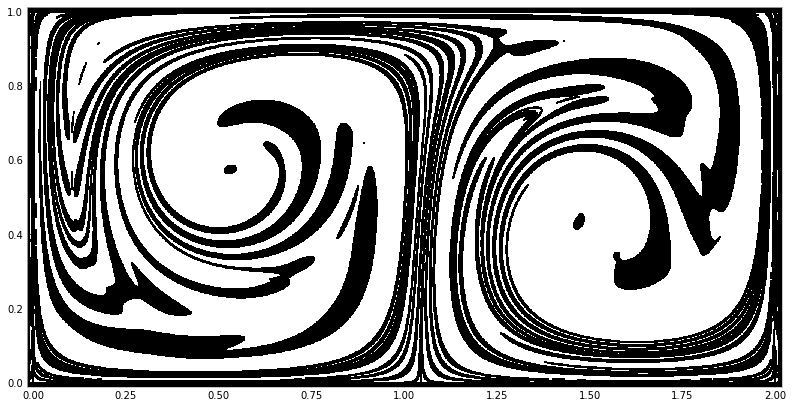

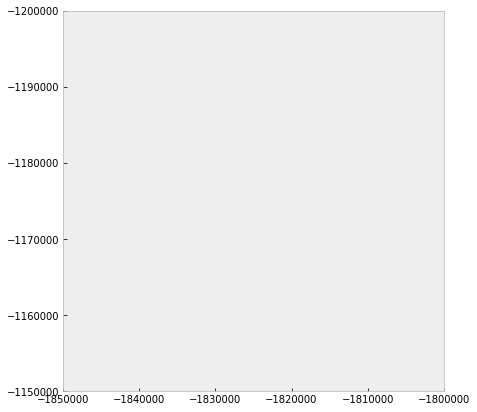

In [17]:
from scipy.ndimage.filters import gaussian_filter
ABtrue__ = gaussian_filter(ABtrue.astype(np.float32), .5)
ABtrue__ = (np.ceil(ABtrue__)).astype(np.int32)


fig = plt.figure(figsize = fig_s)
ax = fig.add_subplot(111, aspect = 'equal')
plt.pcolormesh(xc, yc, ABtrue__.T, cmap = plt.get_cmap('Greys'))
plt.savefig('out' + '/ab_dom' + fig_num + '.png')


fig = plt.figure(figsize = (7, 7))
ax = fig.add_subplot(111, aspect = 'equal')
plt.pcolormesh(xc, yc, ABtrue__.T, cmap = plt.get_cmap('Greys'))

plt.xlim([-1850000, -1800000])
plt.ylim([-1150000, -1200000])
# fig = plt.figure(figsize = fig_s)
# plt.scatter(X0m[0,ABtrue],X0m[1,ABtrue],s=1,marker='.',c='tomato')

In [18]:
# fig = plt.figure(figsize=(10,10))

# plt.pcolormesh(xi1[:,:,0].T)
# # plt.xlim([430, 450])
# # plt.ylim([200, 300])

# fig = plt.figure(figsize=(10,10))

# plt.pcolormesh(xi2[:,:,0].T)
# plt.savefig('egeinfield_%1.5f_.png' % dxa)
# # fig = plt.figure(figsize=(10,10))

# # plt.pcolormesh(median_filter(xi2[:,:,0],3))
# # print(xi1[435:440, 200,0])

In [19]:
mask = np.zeros((Nx + 2*n, Ny + 2*n), dtype = np.bool)
lines = num_lines_ - 0
fig_num += '_lin-' + str(lines - 1)
for i in range(1,lines):
    mask[:,min( int(i*(Ny+1*n)/lines), Ny-1)] = True
    mask[min( int(i*(Nx+1*n)/lines), Nx-1),:] = True

XC, YC = np.meshgrid(xc, yc)  
    
Gx = XC.T[np.logical_and(mask, ABtrue)]
Gy = YC.T[np.logical_and(mask, ABtrue)]

G = np.array([Gx, Gy])

print('G has %s points' % G.shape[1])

G has 3053 points


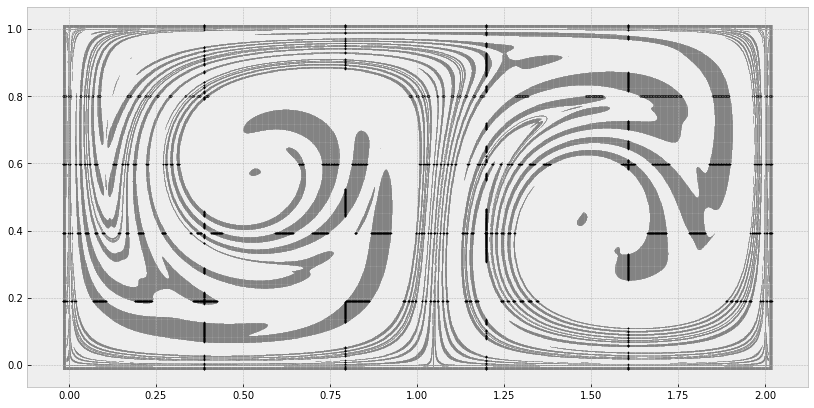

In [20]:
fig = plt.figure(figsize=fig_s)
plt.scatter(XC[ABtrue.T], YC[ABtrue.T],s=1,marker='.',c='grey', alpha=0.3)
plt.scatter(G[0,:], G[1,:], marker = '.', c = 'k', lw = 0.5, s = 5)
# plt.xlim([1.25, 1.5])
# plt.ylim([0.6, 0.8])
plt.savefig('out' + '/G' + fig_num + '.png')

In [21]:
print(X0m.shape)
print(np.array([XC,YC]).shape)

(2, 2000, 1000)
(2, 1016, 2016)


In [22]:
# from scipy.interpolate import RectBivariateSpline
# AB_interp = RectBivariateSpline(xc, yc, ABtrue, kx=3, ky=3)
# new_AB = AB_interp(np.linspace(xc[0], xc[-1], 8000), np.linspace(yc[0], yc[-1], 4000))

In [23]:
# fig = plt.figure(figsize = fig_s)
# ax = fig.add_subplot(111, aspect = 'equal')
# plt.pcolormesh(xc, yc, ABtrue.T, cmap = plt.get_cmap('Greys'))
# plt.xlim([1.25, 1.5])
# plt.ylim([.6, .8])

# fig = plt.figure(figsize = fig_s)
# ax = fig.add_subplot(111, aspect = 'equal')
# plt.pcolormesh(np.linspace(xc[0], xc[-1], 8000), np.linspace(yc[0], yc[-1], 4000), np.where(new_AB.T > .1, 1, 0), cmap = plt.get_cmap('Greys'))
# plt.xlim([1.25, 1.5])
# plt.ylim([.6, .8])
# # new_AB[100,200]

In [24]:
# (int(5*len(G[0,:]) * 1e4*h *1. / (Tmax * 1000)) + 1)

In [25]:
from copy import deepcopy
import cub_strain as c_s
importlib.reload(c_s)
c_s.setNXNY(Nx, Ny, n__)

GRID = np.array([XC, YC])
GRID = GRID.swapaxes(1,2)
EigVec = np.zeros((2, 2, xi1.shape[0], xi1.shape[1]))
EigVec[:, 0, :, :] = np.rollaxis(xi1, 2, 0)
EigVec[:, 1, :, :] = np.rollaxis(xi2, 2, 0)


EigVal = np.zeros((2, lmbd2.shape[0], lmbd2.shape[1]))
EigVal[0, :, :] = lmbd1
EigVal[1, :, :] = lmbd2

f_xi = c_s.CubicSpecial(xc, yc, EigVec[:,0,:,:], n__)

lmdd1 = RectBivariateSpline(xc, yc, lmbd1, kx=2, ky=2)
lmdd2 = RectBivariateSpline(xc, yc, lmbd2, kx=2, ky=2)
lambdas = np.array([lmdd1, lmdd2])

AB_interp = RectBivariateSpline(xc, yc, ABtrue__, kx=2, ky=2)

# List to hold strainlines and associated parameters
# (number not known ahead of time, hence lists)
strainlines   = []
lengths       = []
lengths_notAB = []
eigvals_mean  = []

# Filtering parameters
max_notAB  = 1.50*domain_len / 10
min_length = np.abs(50*strain_res)
# Trajectory integration parameters
# Note: "Speed" is 1 everywhere, since eigenvectors
# are normalised. Thus Tmax gives max length directly
Tmax = np.abs(0.05*strain_res*1e4)
h    = 0.5* strain_res

t_start = time()
progressbar = FloatProgress(min=0, max=100)
display(progressbar)
futures = []
count = 0
"""
This modul variable is for simple load balancing. Ensures a bit more work
to each thread spun up, but not by too much.
"""
modul = 2 + np.abs((int(len(G[0,:])*.2 * 1e4*h / (Tmax * 1000))))
print(modul, 'Lines to each thread')
with ProcessPoolExecutor(n_cpus - 4*(n_cpus > 4 and n_cpus < 16)) as executor:
    for i in range(G.shape[1]):
        count += 1
        if count % int(G.shape[1]/100) == 0: progressbar.value += 1
        if i % modul == 0:
            futures.append(executor.submit(c_s.strainline, G[:,i:i+modul], Tmax, h,\
                                           f_xi, xc, yc, (lambdas), (AB_interp),GRID,\
                                           max_notAB = max_notAB))
        if G.shape[1] - i < modul:
            futures.append(executor.submit(c_s.strainline, G[:,i:], Tmax, h,\
                                           f_xi, xc, yc, (lambdas), (AB_interp),GRID,\
                                           max_notAB = max_notAB))
    
##grid.reshape(2, nx_, ny_)
progressbar = FloatProgress(min=0, max=100)
display(progressbar)
count = 0
for p in as_completed(futures):
    count += 1
    if count % int(G.shape[1]/100) == 0:
        progressbar.value += 1
    try:
        line, length, eigval_mean = p.result()
        for s in range(len(line)):
            if length[s] > min_length:
                strainlines.append(line[s])
                lengths.append(length[s])
                eigvals_mean.append(eigval_mean[s])
    except IndexError:
        pass

print('Identified %s LCS candidates' % len(strainlines))

lengths = np.array(lengths)
eigvals_mean = np.array(eigvals_mean)


t_end = time()
print('In only %d min and %d sec' % (int((t_end - t_start)/60), t_end - t_start - 60*(int((t_end - t_start)/60))))

FloatProgress(value=0.0)

8 Lines to each thread


FloatProgress(value=0.0)

Identified 2912 LCS candidates
In only 7 min and 32 sec


In [26]:
# 1D-arrays of grid coordinates for convenience
xc_ = X0m[0,:,0]
yc_ = X0m[1,0,:]
dx =  xc[1] - xc[0]
dy = yc[1] - yc[0]

inside_eigvals  = []
running_eigvals = []
running_ABtrues = []

progressbar = FloatProgress(min=0, max=len(strainlines))
display(progressbar)

fLCSs = strainlines
flengths = lengths

for i in range(len(strainlines)):
    progressbar.value += 1
    eigvals = np.zeros(strainlines[i].shape[1])
    ABtrues = np.zeros(strainlines[i].shape[1], dtype = np.bool)
    for n in range(strainlines[i].shape[1]):
        #igrid = np.floor(((strainlines[i][0,n]+dx/2) - xc_[0]) / dx).astype(np.int32)
        #jgrid = np.floor(((strainlines[i][1,n]+dy/2) - yc_[0]) / dy).astype(np.int32)
        if AB_interp(strainlines[i][0,n], strainlines[i][1,n]) > .1:#ABtrue[igrid, jgrid]:
            ABtrues[n] = True
            eigvals[n] = lambdas[1](strainlines[i][0,n], strainlines[i][1,n])#EigVal[1,igrid,jgrid]
    inside_eigvals.append(np.sum(eigvals[ABtrues]) / np.sum(ABtrues))
    running_eigvals.append(eigvals)
    running_ABtrues.append(ABtrues)

FloatProgress(value=0.0, max=2912.0)

In [27]:
import os
from os import path

str_path = 'strainlines'
strain_path = str_path + '/strainlines-AB{:05.2f}-h{:1.4f}-nx{:d}-ny{:d}-n{:d}'.format(max_notAB, h, Nx, Ny, (n__))

if not os.path.exists(str_path):
        os.mkdir(str_path)

if not os.path.exists(strain_path):
        os.mkdir(strain_path)

In [28]:
strain_path

'strainlines/strainlines-AB00.30-h0.0005-nx2000-ny1000-n8'

In [29]:


n = n__

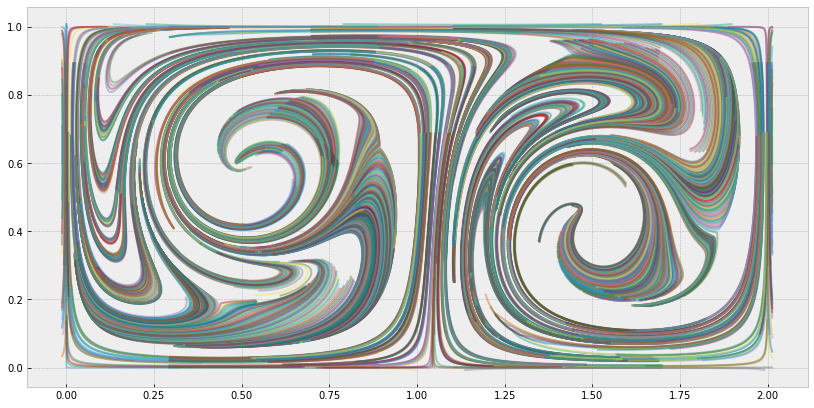

In [30]:
fig = plt.figure(figsize=fig_s)
for i in range(len(fLCSs)):
    plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], alpha=0.4)
plt.savefig(strain_path + '/cool_strainlines' + fig_num + '.png')

In [31]:
#temps

temp_flcs = fLCSs
temp_lens = flengths
temp_eigs = eigvals_mean
print(len(flengths))

2912


In [32]:
fLCSs = temp_flcs
flengths = temp_lens
eigvals_mean = temp_eigs

In [33]:
#removing shorter lines
mult = 0.1

new_lines = []
new_lens = []
new_eigs_mean = []
maks = np.max(flengths)
for i in range(len(fLCSs)):
    if flengths[i] > mult*maks:
        new_lines.append(fLCSs[i])
        new_lens.append(flengths[i])
        new_eigs_mean.append(eigvals_mean[i])
fLCSs = new_lines
flengths = new_lens
eigvals_mean = new_eigs_mean


while(len(fLCSs) > 3000):
    
    new_lines = []
    new_lens = []
    new_eigs_mean = []
    maks = np.max(flengths)
    for i in range(len(fLCSs)):
        if flengths[i] > mult*maks:
            new_lines.append(fLCSs[i])
            new_lens.append(flengths[i])
            new_eigs_mean.append(eigvals_mean[i])
    fLCSs = new_lines
    flengths = new_lens
    eigvals_mean = new_eigs_mean
#     print(len(fLCSs))
    mult += mult/40
print(len(fLCSs))
print(mult)

2912
0.1


In [34]:
# start variables:
# search through longest array and find if shortest starts and ends somewhere on the longest line

# should be possible to iterate through both these lines the same way because the step is the same
# thus if they follow eachother - > should work

# dist = (fLCSs[i][j + start_i,0] - fLCSs[k][j + start_k,0])**2 + (fLCSs[i][j + start_i,1] - fLCSs[k][j + start_k,1])**2
# dist = np.sqrt(dist)

def searcher(short_line, long_line, epsilon):
    tol = 0.3
    if len(short_line[0,:]) > len(long_line[0,:]): 
        print('one faulty boi')
        return -1, -1
    x0, y0 = short_line[:,  0]
    x1, y1 = short_line[:, -1]
    u0, v0 = long_line[:,   0]
    u1, v1 = long_line[:,  -1]
    start = -1
    end = -1
    short = 1 # bool for checking which line to start with
    len_s = len(short_line[0,:])
    len_l = len(long_line[ 0,:])
    #check if short line starts on the long one
    dists = np.sqrt((long_line[0,:] - x0)**2 + (long_line[1,:] - y0)**2)
    start = np.argmin(dists)
    if dists[start] < epsilon:

        dists = np.sqrt((long_line[0,:] - x1)**2 + (long_line[1,:] - y1)**2)
        end = np.argmin(dists)
        if dists[end] < epsilon:
            if (end-start) > tol * len_s:
                return start, end, short
            else:
                return start, -1, short
        
        dists = np.sqrt((short_line[0,:] - u1)**2 + (short_line[1,:] - v1)**2)
        end = np.argmin(dists)
        if dists[end] < epsilon:
            if (end) > tol * len_s:
                return start, len_l - start - 1, short
            else:
                return -1, -1, short
        else:
            return start, -1, short

    else: #if short line dont start on the long line -> check other way around
        short = 0
        dists = np.sqrt((short_line[0,:] - u0)**2 + (short_line[1,:] - v0)**2)
        start = np.argmin(dists)
        if dists[start] > epsilon:
            return -1, -1, short
        
        dists = np.sqrt((long_line[0,:] - x1)**2 + (long_line[1,:] - y1)**2)
        end = np.argmin(dists)
        if dists[end] > 1*epsilon:
            return start, -1, short
        else:
            if (len_s - start) > tol * len_s:

                return start, len_s - start - 1, short
            else: 

                return -1, -1, short

    return start, end, short
        
        
       
        
    

#inner_loop funk


def inner_looper(fLCSs, i, epsilon):
#     print(fLCSs)
    dist = np.zeros(len(fLCSs))
    for j in range(len(fLCSs)):
        if i == j: continue
        len_i = len(fLCSs[i][0,:])
        len_j = len(fLCSs[j][0,:])
        len_short = 0
        length = 0
        end = 0
        start = 0
        nul_val = 1e2
        correction = 0
        if len_j > len_i:
            start, end, order = searcher(fLCSs[i], fLCSs[j], epsilon)
            if start == -1 or end == -1:
                dist[j] = nul_val
                continue
            if end < start:
                temp = start
                start = end
                end = temp

            len_short = end - start

            
            if order:
                start_iter_j = start
                start_iter_i = 0
            else:
                start_iter_i = start
                start_iter_j = 0
            if len_short > len(fLCSs[i][0,:]):
                correction = len_short-len(fLCSs[i][0,:])   
        else:
            start, end, order = searcher(fLCSs[j], fLCSs[i], epsilon)
            if start == -1 or end == -1:
                dist[j] = nul_val
                continue
            if end < start:
                temp = start
                start = end
                end = temp

            len_short = end - start
            
    
            
        
            if order:
                start_iter_j = 0
                start_iter_i = start
            else:
                start_iter_i = 0
                start_iter_j = start
            if len_short > len(fLCSs[j][0,:]):
                correction = len_short-len(fLCSs[j][0,:]) 

                
        
        
        
        
        if end == -1 or start_iter_i == -1 or start_iter_j == -1:
            dist[j] = nul_val
            continue


        distances = np.zeros(len_short)

        len_short -= correction
        if len_short < 1:
            dist[j] = nul_val
            continue
        len_ii = start_iter_i + len_short
        len_jj = start_iter_j + len_short
        
        

        distances = np.sqrt((fLCSs[i][0,start_iter_i:len_ii] - fLCSs[j][0, start_iter_j:len_jj])**2 \
                        + (fLCSs[i][1,start_iter_i:len_ii] - fLCSs[j][1, start_iter_j:len_jj])**2)
        if len_i < len_j:
            x_diff = fLCSs[i][0,start_iter_i + 1:len_ii] - fLCSs[i][0,start_iter_i:len_ii - 1]
            y_diff = fLCSs[i][1,start_iter_i + 1:len_ii] - fLCSs[i][1,start_iter_i:len_ii - 1]
        else:
            x_diff = fLCSs[j][0,start_iter_j + 1:len_jj] - fLCSs[j][0,start_iter_j:len_jj - 1]
            y_diff = fLCSs[j][1,start_iter_j + 1:len_jj] - fLCSs[j][1,start_iter_j:len_jj - 1]
        length = np.sum(np.sqrt(x_diff**2 + y_diff**2))
        dist[j] = np.sum((distances))
        dist[j] = dist[j] / (length * 1)
        
    return dist

# normalize over length of shortest line
   


In [36]:
# flengths,fLCSs, eigvals_mean = (zip(*sorted(list(zip(flengths, fLCSs, eigvals_mean)))))

# import random
# fLCSs = strainlines

# # fig_num = '2'
# c = list(zip(fLCSs, flengths, eigvals_mean))
# #andom.shuffle(c)
# fLCSs, flengths, eigvals_mean = zip(*c)
# #print(fLCSs[0])

nearest_nbs = np.zeros((len(fLCSs), len(fLCSs)))
nearest_nbs.shape
print(fLCSs[0].shape)
epsilon = domain_len / 1

# Progress bar
progressbar = FloatProgress(min = 0, max = int(len(fLCSs) / 20))
display(progressbar)

#first loop: iterate over all lines
##IS THIS SYMMETRIC? problem size could possibly be reduced by factor 2 
short_fLCSs = []
for i in range(len(fLCSs)):
    line = fLCSs[i][:,::20]
    short_fLCSs.append(line)
for i in range(len(fLCSs)):
        nearest_nbs[i,:] = inner_looper(short_fLCSs, i, epsilon)
        if i % 20 == 0: progressbar.value += 1

(2, 1997)


FloatProgress(value=0.0, max=145.0)

In [37]:
# np.where(nearest_nbs > 1e3)

In [38]:
# nearest_nbs[1, 921]

In [39]:
nearest_nbs = np.where(np.isnan(nearest_nbs), 1e2, nearest_nbs)
nearest_nbs_test = np.where(nearest_nbs == 0, 1, nearest_nbs)
nearest_nbs_inv = np.where(nearest_nbs != 0, np.divide(1, nearest_nbs), 1)
mult = .5
NEAREST = np.where(nearest_nbs_inv > 0, 1, 0)


/home/and/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


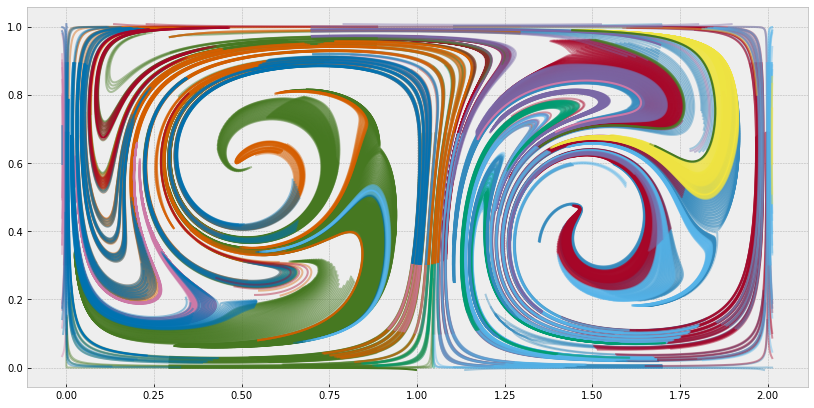

In [40]:
fig = plt.figure(figsize=fig_s)

plotted = set([])
mult = .01
   



for i in range(len(fLCSs)):
    if i not in plotted:
        line1 = fLCSs[i]
        I, = plt.plot(line1[0,:], line1[1,:])
        plotted.add(i)
        threshold = mult#*np.mean(nearest_nbs_inv[i,np.where(nearest_nbs_inv[i,:] > 0 )])
        for j in range(len(fLCSs)):
            if j not in plotted:
                if max(nearest_nbs_inv[i,j], nearest_nbs_inv[j,i]) > threshold:
                    line2 = fLCSs[j]
                    plt.plot(line2[0,:], line2[1,:], c = I.get_color(), alpha=0.4)
                    plotted.add(j)
# plt.savefig('out/neighbours' + fig_num +'.png')
plt.show()

In [41]:
# fig = plt.figure(figsize=fig_s)
# for i in range(21, 22):
#     plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], alpha=0.8)
# plt.show()
# print(fLCSs[i][0,:])
# for j in range(alen(fLCSs[i][0,:])):
#     print('x: %0.5f, y: %0.5f' % (fLCSs[i][0,j], fLCSs[i][1,j]))

In [42]:
# %matplotlib notebook

[   0    1    2    3    4    5    6    7  120  121  122  123  124  125
  126  127  128  129  130  131  132  133  134  135  142  143  384  387
  390  416  418  420  422  450  453  497  500  503  554  557  576  579
  582  625  628  631  688  691  694  801  804  807  818  821  864  867
  870  929  932  935  944  945  946  947  948  949  950  951  954  957
  960  961  962  963  964  965  966  967  992  995  998 1019 1020 1021
 1022 1023 1034 1037 1129 1132 1135 1696 1698 1700 1728 1729 1798 1888
 1889 1890 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907
 1908 1909 1910 1911 1923 1926 2000 2001 2002 2003 2004 2005 2006 2007
 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021
 2022 2023 2024 2025 2026 2027 2028 2029 2030 2031 2032 2033 2034 2035
 2036 2037 2038 2039 2040 2041 2042 2043 2044 2045 2046 2047 2048 2049
 2050 2051 2052 2053 2054 2055]
0.05


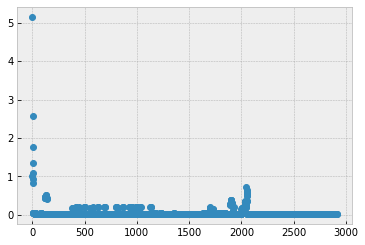

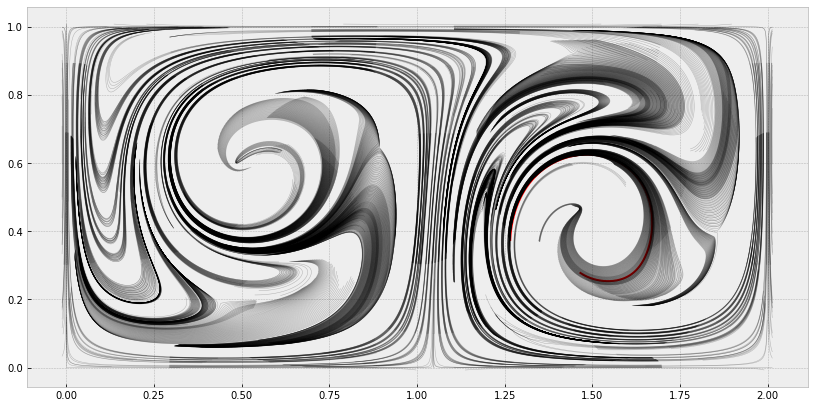

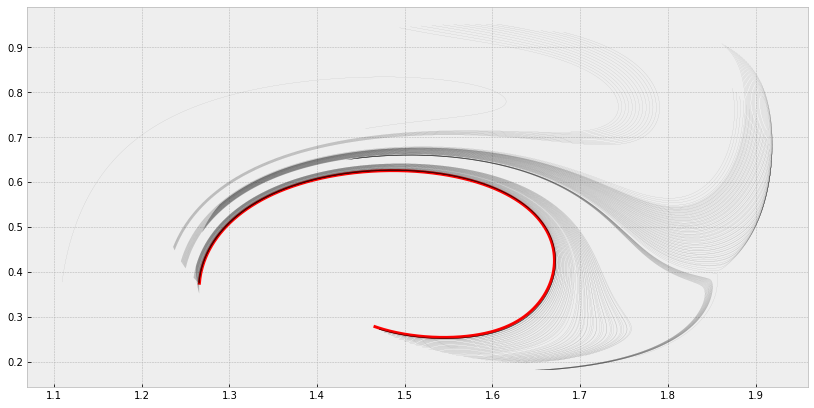

In [43]:
num =0
mult = 5e-2
   
threshold = 1*mult#*np.mean(nearest_nbs_inv[num,np.where(nearest_nbs_inv[num,:] > 0 )])



plt.plot(np.linspace(0,nearest_nbs.shape[0], nearest_nbs.shape[0]),nearest_nbs_inv[num,:],'o')
#pick closest lines
friendsof_num = np.where(nearest_nbs_inv[num,:] > threshold )
friendsof_num[0]
fig = plt.figure(figsize=fig_s)
plt.plot(fLCSs[num][0,:], fLCSs[num][1,:], c = 'r', lw = 2)
for i in range(len(fLCSs)):
    plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = 0.5, alpha=0.25 )
    
alphas = np.exp(nearest_nbs_inv[num,friendsof_num[0]])
alphas = np.sqrt(alphas / np.max(alphas))

#plot to see if it makes sense
fig = plt.figure(figsize=fig_s)
plt.plot(fLCSs[num][0,:], fLCSs[num][1,:], c = 'r', lw = 3 )
count = 0
for i in set(friendsof_num[0]):
    plt.plot(fLCSs[i][0,:], fLCSs[i][1,:], c = 'k', lw = alphas[count] * .5, alpha=1)
    count+=1
    
print(friendsof_num[0])
print(threshold)
# alphas

In [44]:
# fLCSs = strainlines
minn = len(fLCSs[0][0,:])
maxx = 0
for i in range(len(fLCSs)):
    if(len(fLCSs[i][0,:]) < minn):
        minn = len(fLCSs[i][0,])
    if(len(fLCSs[i][0,:]) > maxx):
        maxx = len(fLCSs[i][0,])

print('max length of LCS: %d' % maxx)
print('min length of LCS: %d' % minn)

max length of LCS: 1997
min length of LCS: 223


In [45]:
ABtrue = ABtrue_
lambda2 = lmbd2_

In [46]:
from scipy.interpolate import UnivariateSpline, interp1d
divider = 5
size = 2000#int(maxx/divider)
X = np.zeros((len(fLCSs), size))
y = np.zeros((len(fLCSs), size))
eigs = np.zeros((len(fLCSs), size))
for i in range(len(fLCSs)):
    leng = int(len(fLCSs[i][0,]))
    x_diff = np.zeros(leng)
    y_diff = np.zeros(leng)
    x_diff[1:-1] = fLCSs[i][0,1:-1] - fLCSs[i][0,0:-2]
    y_diff[1:-1] = fLCSs[i][1,1:-1] - fLCSs[i][1,0:-2]
    
    xs = np.cumsum(np.sqrt(x_diff**2 + y_diff**2))
    xs = xs / xs[-1]
#     xs = xs[::divider]
#     print(xs)
    spline_x = interp1d(x=xs, y=fLCSs[i][0,])
    spline_y = interp1d(x=xs, y=fLCSs[i][1,])
    x_long = np.linspace(0, 1, size)
    X[i,:] = spline_x(x_long)
    y[i,:] = spline_y(x_long)
    
#     ratio = 1 - len(fLCSs[i][0,:]) / size
#     multiplier = int(len(fLCSs[i][0,:]) / size)
#     offset = 0


#     for j in range(size):#len(fLCSs[i][0,:])):
        
#         X[i, j + offset] = fLCSs[i][0, j * multiplier]
#         y[i, j + offset] = fLCSs[i][1, j * multiplier]



In [47]:
np.save(strain_path + '/strainlines.npy', np.array([X, y]))
np.save(strain_path + '/flengths.npy', flengths)
np.save(strain_path + '/eigvals_mean.npy', eigvals_mean)
np.save(strain_path + '/lambda2.npy', lambda2)
np.save(strain_path + '/ABtrue.npy', ABtrue)
np.save(strain_path + '/nearest_nbs.npy', nearest_nbs)
np.save(strain_path + '/figure_name.npy', fig_num)